# 伤害期望和最优数值关系

In [70]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

## 不考虑元素反应的情况下

In [22]:
characters = pd.DataFrame(
    [
        # 迪卢克升级加 19.2% 的暴击率，不考虑迪卢克天赋提供的附魔期间火元素伤害加成
        ['迪卢克', '双手剑', 335, .05 + .192, .5, 0],
        ['凝光', '法器', 212, .05, .5, .27]
    ],
    columns=['名字', '武器类型', '攻击力', '暴击率', '暴击伤害', '额外增伤'],
)

characters

,名字,武器类型,攻击力,暴击率,暴击伤害,额外增伤
0,迪卢克,双手剑,335,0.242,0.5,0.00
1,凝光,法器,212,0.050,0.5,0.27


In [65]:
# 武器都为精炼 1 的效果

weapons = pd.DataFrame(
    [
        # 30% 血量以下的敌人攻击力增加 40%，持续 12s，冷却 30s，计算期望增加攻击力 30%*40%*12/30
        ['狼的末路', '双手剑', 608, .496 + .2 + .3*.4*12/30, 0, 0, 0],
        # 螭骨剑的增伤效果一般在实战中视为为 2 层左右
        ['螭骨剑', '双手剑', 510, 0, .276, 0, .06 * 2],
        # 试作古华的伤害特效不考虑
        ['试作古华', '双手剑', 565, .276, 0, 0, 0],
        ['四风原典', '法器', 608, 0, .311, .16, 0],
        ['匣里日月', '法器', 510, 0, .276, 0, 0],
        
    ],
    columns=['名称', '武器类型', '攻击力', '百分比攻击力', '暴击率', '暴击伤害', '额外增伤'],
)

weapons

,名称,武器类型,攻击力,百分比攻击力,暴击率,暴击伤害,额外增伤
0,狼的末路,双手剑,608,0.744,0.000,0.00,0.00
1,螭骨剑,双手剑,510,0.000,0.276,0.00,0.12
2,试作古华,双手剑,565,0.276,0.000,0.00,0.00
3,四风原典,法器,608,0.000,0.311,0.16,0.00
4,匣里日月,法器,510,0.000,0.276,0.00,0.00


In [25]:
artifacts = pd.DataFrame(
    [
        # 卢姥爷释放元素战技三次一共增加元素伤害 15% + 7.5%*3 = 37.5%
        ['炽烈的炎之魔女', 0, 0, 0, 0, .15 + .075*3],
        ['悠古的磐岩', 0, 0, 0, 0, .15]
        
    ],
    columns=['名称', '数值攻击力', '百分比攻击力', '暴击率', '暴击伤害', '额外增伤'],
)

artifacts

,名称,数值攻击力,百分比攻击力,暴击率,暴击伤害,额外增伤
0,炽烈的炎之魔女,0,0,0,0,0.375
1,悠古的磐岩,0,0,0,0,0.150


In [26]:
# 输入主副词条属性值

attr_names = [
    '主_百分比攻击力', 
    '主_元素伤害', 
    '主_暴击率', 
    '主_暴击伤害',
    '副_数值攻击力',
    '副_百分比攻击力',
    '副_暴击率',
    '副_暴击伤害',
]
attr_values = [.466, .466, .311, .622, 17, .05, .033, .066]

In [7]:
def gen_sub_stats(sands, goblet, circlet):
    attr_len = len(attr_names)
    values = [0] * (attr_len * 2)
    half_len = int(attr_len / 2)
    
    # 录入主词条
    values[sands] += attr_values[sands]
    values[goblet] += attr_values[goblet]
    values[circlet] += attr_values[circlet]
    values[attr_len + sands] += 1
    values[attr_len + goblet] += 1
    values[attr_len + circlet] += 1
    
    # 初始出现的副词条（假设最好的情况，且不与主词条重复）
    ini_atk = 4
    ini_patk = 5 - values[attr_len]
    ini_crate = 5 - values[attr_len + 2]
    ini_cdmg = 5 - values[attr_len + 3]
    
    # 升级出现的副词条(枚举总数不超过 25)
    print('沙、杯、帽')
    print(sands, goblet, circlet)
    max_idx_atk = min(ini_atk * 5, 25)
    for idx_atk in range(max_idx_atk + 1):
        max_idx_patk = min(idx_atk + ini_patk * 5, 25)
        for idx_patk in range(idx_atk, max_idx_patk + 1):
            max_idx_crate = min(idx_patk + ini_crate * 5, 25)
            for idx_crate in range(idx_patk, max_idx_crate + 1):
                max_idx_cdmg = idx_crate + ini_cdmg * 5
                # 全部副词条不足 25 次，即不是全部加在攻击力，暴击爆伤上
                if max_idx_cdmg < 25:
                    continue
                up_atk = idx_atk
                up_patk = idx_patk - idx_atk
                up_crate = idx_crate - idx_patk
                up_cdmg = 25 - idx_crate
                values[attr_len + half_len + 0] = ini_atk + up_atk
                values[attr_len + half_len + 1] = ini_patk + up_patk
                values[attr_len + half_len + 2] = ini_crate + up_crate
                values[attr_len + half_len + 3] = ini_cdmg + up_cdmg
                for idx in range(4):
                    values[half_len + idx] = (
                        values[attr_len + half_len + idx] * 
                        attr_values[half_len + idx]
                    )
                equip_values.loc[len(equip_values)] = values

In [8]:
%%time

# 花和羽毛主词条固定，沙漏默认带攻击（不考虑元素反应），其他枚举
attr_cols = attr_names + [name + '_次数' for name in attr_names]
equip_values = pd.DataFrame(columns=attr_cols)

for goblet in [0, 1]:
    for circlet in [0, 2, 3]:
        gen_sub_stats(0, goblet, circlet)

equip_values.insert(0, '主_数值攻击力', 311)

equip_values.head(10)

沙、杯、帽
0 0 0
沙、杯、帽
0 0 2
沙、杯、帽
0 0 3
沙、杯、帽
0 1 0
沙、杯、帽
0 1 2
沙、杯、帽
0 1 3
CPU times: user 25.4 s, sys: 1.02 s, total: 26.4 s
Wall time: 26.5 s


,主_数值攻击力,主_百分比攻击力,主_元素伤害,主_暴击率,主_暴击伤害,副_数值攻击力,副_百分比攻击力,副_暴击率,副_暴击伤害,主_百分比攻击力_次数,主_元素伤害_次数,主_暴击率_次数,主_暴击伤害_次数,副_数值攻击力_次数,副_百分比攻击力_次数,副_暴击率_次数,副_暴击伤害_次数
0,311,1.398,0.0,0.0,0.0,68.0,0.1,0.165,1.980,3.0,0.0,0.0,0.0,4.0,2.0,5.0,30.0
1,311,1.398,0.0,0.0,0.0,68.0,0.1,0.198,1.914,3.0,0.0,0.0,0.0,4.0,2.0,6.0,29.0
2,311,1.398,0.0,0.0,0.0,68.0,0.1,0.231,1.848,3.0,0.0,0.0,0.0,4.0,2.0,7.0,28.0
3,311,1.398,0.0,0.0,0.0,68.0,0.1,0.264,1.782,3.0,0.0,0.0,0.0,4.0,2.0,8.0,27.0
4,311,1.398,0.0,0.0,0.0,68.0,0.1,0.297,1.716,3.0,0.0,0.0,0.0,4.0,2.0,9.0,26.0
5,311,1.398,0.0,0.0,0.0,68.0,0.1,0.330,1.650,3.0,0.0,0.0,0.0,4.0,2.0,10.0,25.0
6,311,1.398,0.0,0.0,0.0,68.0,0.1,0.363,1.584,3.0,0.0,0.0,0.0,4.0,2.0,11.0,24.0
7,311,1.398,0.0,0.0,0.0,68.0,0.1,0.396,1.518,3.0,0.0,0.0,0.0,4.0,2.0,12.0,23.0
8,311,1.398,0.0,0.0,0.0,68.0,0.1,0.429,1.452,3.0,0.0,0.0,0.0,4.0,2.0,13.0,22.0
9,311,1.398,0.0,0.0,0.0,68.0,0.1,0.462,1.386,3.0,0.0,0.0,0.0,4.0,2.0,14.0,21.0


In [10]:
len(equip_values)

17896

In [11]:
# 计算仅由圣遗物主副词条带来的数值

origin_names = ['数值攻击力', '百分比攻击力', '元素伤害', '暴击率', '暴击伤害']
for name in origin_names:
    main_stat = equip_values['主_' + name]
    sub_stat = (
        ('副_' + name) in equip_values.columns and 
        equip_values['副_' + name]
    )
    equip_values['总_' + name] = main_stat + sub_stat

equip_values['总_额外增伤'] = equip_values['总_元素伤害']
equip_values.head()

,主_数值攻击力,主_百分比攻击力,主_元素伤害,主_暴击率,主_暴击伤害,副_数值攻击力,副_百分比攻击力,副_暴击率,副_暴击伤害,主_百分比攻击力_次数,主_元素伤害_次数,主_暴击率_次数,主_暴击伤害_次数,副_数值攻击力_次数,副_百分比攻击力_次数,副_暴击率_次数,副_暴击伤害_次数,总_数值攻击力,总_百分比攻击力,总_元素伤害,总_暴击率,总_暴击伤害,总_额外增伤
0,311,1.398,0.0,0.0,0.0,68.0,0.1,0.165,1.980,3.0,0.0,0.0,0.0,4.0,2.0,5.0,30.0,379.0,1.498,0.0,0.165,1.980,0.0
1,311,1.398,0.0,0.0,0.0,68.0,0.1,0.198,1.914,3.0,0.0,0.0,0.0,4.0,2.0,6.0,29.0,379.0,1.498,0.0,0.198,1.914,0.0
2,311,1.398,0.0,0.0,0.0,68.0,0.1,0.231,1.848,3.0,0.0,0.0,0.0,4.0,2.0,7.0,28.0,379.0,1.498,0.0,0.231,1.848,0.0
3,311,1.398,0.0,0.0,0.0,68.0,0.1,0.264,1.782,3.0,0.0,0.0,0.0,4.0,2.0,8.0,27.0,379.0,1.498,0.0,0.264,1.782,0.0
4,311,1.398,0.0,0.0,0.0,68.0,0.1,0.297,1.716,3.0,0.0,0.0,0.0,4.0,2.0,9.0,26.0,379.0,1.498,0.0,0.297,1.716,0.0


In [57]:
def fit_ct(ct_name, af_name):
    results = []
    
    cts = characters[characters['名字'] == ct_name]
    wps = weapons[weapons['武器类型'] == cts['武器类型'].values[0]]
    afs = artifacts[artifacts['名称'] == af_name]
    
    for _, ct in cts.iterrows():
        for _, wp in wps.iterrows():
            for _, af in afs.iterrows():
                print(ct['名字'], wp['名称'], af['名称'])
                # 加成人物和武器的属性
                e_values = equip_values.copy()
                for attr in ct.index[3:]:
                    e_values['总_' + attr] += ct[attr]
                for attr in wp.index[3:]:
                    e_values['总_' + attr] += wp[attr]
                for attr in af.index[1:]:
                    e_values['总_' + attr] += af[attr]

                print(ct['攻击力'], wp['攻击力'])

                e_values['期望伤害'] = (
                    (
                        (ct['攻击力'] + wp['攻击力']) *
                        (1 + e_values['总_百分比攻击力']) + 
                        e_values['总_数值攻击力']
                    ) *
                    (1 + e_values['总_额外增伤']) *
                    (
                        1 + 
                        # 暴击率超过 1，只能按 1 计算
                        e_values['总_暴击率'].where(e_values['总_暴击率'] < 1, 1) * 
                        e_values['总_暴击伤害']
                    )
                )

                e_values['总攻击力倍数'] = (
                    (
                        (ct['攻击力'] + wp['攻击力']) *
                        (1 + e_values['总_百分比攻击力']) + 
                        e_values['总_数值攻击力']
                    ) / 
                    (ct['攻击力'] + wp['攻击力'])
                )

                e_values['暴击率推导的总攻击力倍数'] = 1.52 * (
                    1 / (2 * e_values['总_暴击率']) + e_values['总_暴击率']
                )

                res = e_values.sort_values('期望伤害', ascending=False)
                print(res.iloc[:5])
                results.append(res)
                # res.to_csv(ct['名字'] + '_' + wp['名称'] + '_' + af['名称'] +'.csv')

    return results

In [58]:
results = fit_ct('迪卢克', '炽烈的炎之魔女')

迪卢克 狼的末路 炽烈的炎之魔女
335 608
       主_数值攻击力  主_百分比攻击力  主_元素伤害  主_暴击率  主_暴击伤害  副_数值攻击力  副_百分比攻击力  副_暴击率  \
14737      311     0.466   0.466  0.000   0.622     68.0       0.2  0.726   
11562      311     0.466   0.466  0.311   0.000     68.0       0.2  0.396   
11563      311     0.466   0.466  0.311   0.000     68.0       0.2  0.429   
14736      311     0.466   0.466  0.000   0.622     68.0       0.2  0.693   
11561      311     0.466   0.466  0.311   0.000     68.0       0.2  0.363   

       副_暴击伤害  主_百分比攻击力_次数  主_元素伤害_次数  主_暴击率_次数  主_暴击伤害_次数  副_数值攻击力_次数  \
14737   0.792          1.0        1.0       0.0        1.0         4.0   
11562   1.452          1.0        1.0       1.0        0.0         4.0   
11563   1.386          1.0        1.0       1.0        0.0         4.0   
14736   0.858          1.0        1.0       0.0        1.0         4.0   
11561   1.518          1.0        1.0       1.0        0.0         4.0   

       副_百分比攻击力_次数  副_暴击率_次数  副_暴击伤害_次数  总_数值攻击力  总_百分比攻击力  总_元素伤害 

In [59]:
results[0].iloc[:10]

,主_数值攻击力,主_百分比攻击力,主_元素伤害,主_暴击率,主_暴击伤害,副_数值攻击力,副_百分比攻击力,副_暴击率,副_暴击伤害,主_百分比攻击力_次数,主_元素伤害_次数,主_暴击率_次数,主_暴击伤害_次数,副_数值攻击力_次数,副_百分比攻击力_次数,副_暴击率_次数,副_暴击伤害_次数,总_数值攻击力,总_百分比攻击力,总_元素伤害,总_暴击率,总_暴击伤害,总_额外增伤,期望伤害,总攻击力倍数,暴击率推导的总攻击力倍数
14737,311,0.466,0.466,0.000,0.622,68.0,0.20,0.726,0.792,1.0,1.0,0.0,1.0,4.0,4.0,22.0,12.0,379.0,1.41,0.466,0.968,1.914,0.841,13926.139169,2.811909,2.256484
11562,311,0.466,0.466,0.311,0.000,68.0,0.20,0.396,1.452,1.0,1.0,1.0,0.0,4.0,4.0,12.0,22.0,379.0,1.41,0.466,0.949,1.952,0.841,13924.655147,2.811909,2.243323
11563,311,0.466,0.466,0.311,0.000,68.0,0.20,0.429,1.386,1.0,1.0,1.0,0.0,4.0,4.0,13.0,21.0,379.0,1.41,0.466,0.982,1.886,0.841,13922.722013,2.811909,2.266571
14736,311,0.466,0.466,0.000,0.622,68.0,0.20,0.693,0.858,1.0,1.0,0.0,1.0,4.0,4.0,21.0,13.0,379.0,1.41,0.466,0.935,1.980,0.841,13919.051012,2.811909,2.234034
11561,311,0.466,0.466,0.311,0.000,68.0,0.20,0.363,1.518,1.0,1.0,1.0,0.0,4.0,4.0,11.0,23.0,379.0,1.41,0.466,0.916,2.018,0.841,13905.323809,2.811909,2.222014
14738,311,0.466,0.466,0.000,0.622,68.0,0.20,0.759,0.726,1.0,1.0,0.0,1.0,4.0,4.0,23.0,11.0,379.0,1.41,0.466,1.001,1.848,0.841,13902.941564,2.811909,2.280761
14735,311,0.466,0.466,0.000,0.622,68.0,0.20,0.660,0.924,1.0,1.0,0.0,1.0,4.0,4.0,20.0,14.0,379.0,1.41,0.466,0.902,2.046,0.841,13890.698384,2.811909,2.213612
11560,311,0.466,0.466,0.311,0.000,68.0,0.20,0.330,1.584,1.0,1.0,1.0,0.0,4.0,4.0,10.0,24.0,379.0,1.41,0.466,0.883,2.084,0.841,13864.728001,2.811909,2.202862
11583,311,0.466,0.466,0.311,0.000,68.0,0.25,0.396,1.386,1.0,1.0,1.0,0.0,4.0,5.0,12.0,21.0,379.0,1.46,0.466,0.949,1.886,0.841,13861.062472,2.861909,2.243323
14758,311,0.466,0.466,0.000,0.622,68.0,0.25,0.693,0.792,1.0,1.0,0.0,1.0,4.0,5.0,21.0,12.0,379.0,1.46,0.466,0.935,1.914,0.841,13859.949538,2.861909,2.234034


In [60]:
results[1].iloc[:10]

,主_数值攻击力,主_百分比攻击力,主_元素伤害,主_暴击率,主_暴击伤害,副_数值攻击力,副_百分比攻击力,副_暴击率,副_暴击伤害,主_百分比攻击力_次数,主_元素伤害_次数,主_暴击率_次数,主_暴击伤害_次数,副_数值攻击力_次数,副_百分比攻击力_次数,副_暴击率_次数,副_暴击伤害_次数,总_数值攻击力,总_百分比攻击力,总_元素伤害,总_暴击率,总_暴击伤害,总_额外增伤,期望伤害,总攻击力倍数,暴击率推导的总攻击力倍数
11660,311,0.466,0.466,0.311,0.000,68.0,0.45,0.165,1.584,1.0,1.0,1.0,0.0,4.0,9.0,5.0,24.0,379.0,0.916,0.466,0.994,2.084,0.961,12034.481369,2.364521,2.275468
11639,311,0.466,0.466,0.311,0.000,68.0,0.40,0.165,1.650,1.0,1.0,1.0,0.0,4.0,8.0,5.0,25.0,379.0,0.866,0.466,0.994,2.150,0.961,12031.609737,2.314521,2.275468
14839,311,0.466,0.466,0.000,0.622,68.0,0.45,0.462,0.990,1.0,1.0,0.0,1.0,4.0,9.0,14.0,15.0,379.0,0.916,0.466,0.980,2.112,0.961,12027.679517,2.364521,2.265110
11681,311,0.466,0.466,0.311,0.000,68.0,0.50,0.165,1.518,1.0,1.0,1.0,0.0,4.0,10.0,5.0,23.0,379.0,0.966,0.466,0.994,2.018,0.961,12026.482122,2.414521,2.275468
14860,311,0.466,0.466,0.000,0.622,68.0,0.50,0.462,0.924,1.0,1.0,0.0,1.0,4.0,10.0,14.0,14.0,379.0,0.966,0.466,0.980,2.046,0.961,12023.233335,2.414521,2.265110
14817,311,0.466,0.466,0.000,0.622,68.0,0.40,0.462,1.056,1.0,1.0,0.0,1.0,4.0,8.0,14.0,16.0,379.0,0.866,0.466,0.980,2.178,0.961,12021.407933,2.314521,2.265110
11618,311,0.466,0.466,0.311,0.000,68.0,0.35,0.165,1.716,1.0,1.0,1.0,0.0,4.0,7.0,5.0,26.0,379.0,0.816,0.466,0.994,2.216,0.961,12017.867228,2.264521,2.275468
11680,311,0.466,0.466,0.311,0.000,68.0,0.50,0.132,1.584,1.0,1.0,1.0,0.0,4.0,10.0,4.0,24.0,379.0,0.966,0.466,0.961,2.084,0.961,12013.807051,2.414521,2.251563
11659,311,0.466,0.466,0.311,0.000,68.0,0.45,0.132,1.650,1.0,1.0,1.0,0.0,4.0,9.0,4.0,25.0,379.0,0.916,0.466,0.961,2.150,0.961,12013.535114,2.364521,2.251563
14880,311,0.466,0.466,0.000,0.622,68.0,0.55,0.462,0.858,1.0,1.0,0.0,1.0,4.0,11.0,14.0,13.0,379.0,1.016,0.466,0.980,1.980,0.961,12008.069385,2.464521,2.265110


In [61]:
results[2].iloc[:10]

,主_数值攻击力,主_百分比攻击力,主_元素伤害,主_暴击率,主_暴击伤害,副_数值攻击力,副_百分比攻击力,副_暴击率,副_暴击伤害,主_百分比攻击力_次数,主_元素伤害_次数,主_暴击率_次数,主_暴击伤害_次数,副_数值攻击力_次数,副_百分比攻击力_次数,副_暴击率_次数,副_暴击伤害_次数,总_数值攻击力,总_百分比攻击力,总_元素伤害,总_暴击率,总_暴击伤害,总_额外增伤,期望伤害,总攻击力倍数,暴击率推导的总攻击力倍数
14737,311,0.466,0.466,0.000,0.622,68.0,0.20,0.726,0.792,1.0,1.0,0.0,1.0,4.0,4.0,22.0,12.0,379.0,0.942,0.466,0.968,1.914,0.841,11169.775868,2.363111,2.256484
11562,311,0.466,0.466,0.311,0.000,68.0,0.20,0.396,1.452,1.0,1.0,1.0,0.0,4.0,4.0,12.0,22.0,379.0,0.942,0.466,0.949,1.952,0.841,11168.585574,2.363111,2.243323
11563,311,0.466,0.466,0.311,0.000,68.0,0.20,0.429,1.386,1.0,1.0,1.0,0.0,4.0,4.0,13.0,21.0,379.0,0.942,0.466,0.982,1.886,0.841,11167.035060,2.363111,2.266571
14736,311,0.466,0.466,0.000,0.622,68.0,0.20,0.693,0.858,1.0,1.0,0.0,1.0,4.0,4.0,21.0,13.0,379.0,0.942,0.466,0.935,1.980,0.841,11164.090650,2.363111,2.234034
11583,311,0.466,0.466,0.311,0.000,68.0,0.25,0.396,1.386,1.0,1.0,1.0,0.0,4.0,5.0,12.0,21.0,379.0,0.992,0.466,0.949,1.886,0.841,11154.468121,2.413111,2.243323
14758,311,0.466,0.466,0.000,0.622,68.0,0.25,0.693,0.792,1.0,1.0,0.0,1.0,4.0,5.0,21.0,12.0,379.0,0.992,0.466,0.935,1.914,0.841,11153.572506,2.413111,2.234034
11561,311,0.466,0.466,0.311,0.000,68.0,0.20,0.363,1.518,1.0,1.0,1.0,0.0,4.0,4.0,11.0,23.0,379.0,0.942,0.466,0.916,2.018,0.841,11153.080437,2.363111,2.222014
14738,311,0.466,0.466,0.000,0.622,68.0,0.20,0.759,0.726,1.0,1.0,0.0,1.0,4.0,4.0,23.0,11.0,379.0,0.942,0.466,1.001,1.848,0.841,11151.169702,2.363111,2.280761
14759,311,0.466,0.466,0.000,0.622,68.0,0.25,0.726,0.726,1.0,1.0,0.0,1.0,4.0,5.0,22.0,11.0,379.0,0.992,0.466,0.968,1.848,0.841,11150.669752,2.413111,2.256484
11582,311,0.466,0.466,0.311,0.000,68.0,0.25,0.363,1.452,1.0,1.0,1.0,0.0,4.0,5.0,11.0,22.0,379.0,0.992,0.466,0.916,1.952,0.841,11147.343179,2.413111,2.222014


In [66]:
results = fit_ct('凝光', '悠古的磐岩')

凝光 四风原典 悠古的磐岩
212 608
       主_数值攻击力  主_百分比攻击力  主_元素伤害  主_暴击率  主_暴击伤害  副_数值攻击力  副_百分比攻击力  副_暴击率  \
14822      311     0.466   0.466  0.000   0.622     68.0      0.40  0.627   
14800      311     0.466   0.466  0.000   0.622     68.0      0.35  0.627   
11643      311     0.466   0.466  0.311   0.000     68.0      0.40  0.297   
14844      311     0.466   0.466  0.000   0.622     68.0      0.45  0.627   
11664      311     0.466   0.466  0.311   0.000     68.0      0.45  0.297   

       副_暴击伤害  主_百分比攻击力_次数  主_元素伤害_次数  主_暴击率_次数  主_暴击伤害_次数  副_数值攻击力_次数  \
14822   0.726          1.0        1.0       0.0        1.0         4.0   
14800   0.792          1.0        1.0       0.0        1.0         4.0   
11643   1.386          1.0        1.0       1.0        0.0         4.0   
14844   0.660          1.0        1.0       0.0        1.0         4.0   
11664   1.320          1.0        1.0       1.0        0.0         4.0   

       副_百分比攻击力_次数  副_暴击率_次数  副_暴击伤害_次数  总_数值攻击力  总_百分比攻击力  总_元素伤害  总_

In [67]:
results[0].head()

,主_数值攻击力,主_百分比攻击力,主_元素伤害,主_暴击率,主_暴击伤害,副_数值攻击力,副_百分比攻击力,副_暴击率,副_暴击伤害,主_百分比攻击力_次数,主_元素伤害_次数,主_暴击率_次数,主_暴击伤害_次数,副_数值攻击力_次数,副_百分比攻击力_次数,副_暴击率_次数,副_暴击伤害_次数,总_数值攻击力,总_百分比攻击力,总_元素伤害,总_暴击率,总_暴击伤害,总_额外增伤,期望伤害,总攻击力倍数,暴击率推导的总攻击力倍数
14822,311,0.466,0.466,0.000,0.622,68.0,0.40,0.627,0.726,1.0,1.0,0.0,1.0,4.0,8.0,19.0,11.0,379.0,0.866,0.466,0.988,2.008,0.886,10743.845697,2.328195,2.270991
14800,311,0.466,0.466,0.000,0.622,68.0,0.35,0.627,0.792,1.0,1.0,0.0,1.0,4.0,7.0,19.0,12.0,379.0,0.816,0.466,0.988,2.074,0.886,10742.858008,2.278195,2.270991
11643,311,0.466,0.466,0.311,0.000,68.0,0.40,0.297,1.386,1.0,1.0,1.0,0.0,4.0,8.0,9.0,21.0,379.0,0.866,0.466,0.969,2.046,0.886,10739.056899,2.328195,2.257194
14844,311,0.466,0.466,0.000,0.622,68.0,0.45,0.627,0.660,1.0,1.0,0.0,1.0,4.0,9.0,19.0,10.0,379.0,0.916,0.466,0.988,1.942,0.886,10734.748838,2.378195,2.270991
11664,311,0.466,0.466,0.311,0.000,68.0,0.45,0.297,1.320,1.0,1.0,1.0,0.0,4.0,9.0,9.0,20.0,379.0,0.916,0.466,0.969,1.980,0.886,10734.469316,2.378195,2.257194


In [68]:
results[1].head()

,主_数值攻击力,主_百分比攻击力,主_元素伤害,主_暴击率,主_暴击伤害,副_数值攻击力,副_百分比攻击力,副_暴击率,副_暴击伤害,主_百分比攻击力_次数,主_元素伤害_次数,主_暴击率_次数,主_暴击伤害_次数,副_数值攻击力_次数,副_百分比攻击力_次数,副_暴击率_次数,副_暴击伤害_次数,总_数值攻击力,总_百分比攻击力,总_元素伤害,总_暴击率,总_暴击伤害,总_额外增伤,期望伤害,总攻击力倍数,暴击率推导的总攻击力倍数
14757,311,0.466,0.466,0.000,0.622,68.0,0.25,0.660,0.858,1.0,1.0,0.0,1.0,4.0,5.0,20.0,13.0,379.0,0.716,0.466,0.986,1.980,0.886,9008.756865,2.240931,2.269511
11602,311,0.466,0.466,0.311,0.000,68.0,0.30,0.330,1.452,1.0,1.0,1.0,0.0,4.0,6.0,10.0,22.0,379.0,0.766,0.466,0.967,1.952,0.886,9007.939774,2.290931,2.255776
11582,311,0.466,0.466,0.311,0.000,68.0,0.25,0.363,1.452,1.0,1.0,1.0,0.0,4.0,5.0,11.0,22.0,379.0,0.716,0.466,1.000,1.952,0.886,9007.902457,2.240931,2.280000
14779,311,0.466,0.466,0.000,0.622,68.0,0.30,0.660,0.792,1.0,1.0,0.0,1.0,4.0,6.0,20.0,12.0,379.0,0.766,0.466,0.986,1.914,0.886,9006.754348,2.290931,2.269511
11581,311,0.466,0.466,0.311,0.000,68.0,0.25,0.330,1.518,1.0,1.0,1.0,0.0,4.0,5.0,10.0,23.0,379.0,0.716,0.466,0.967,2.018,0.886,9006.089892,2.240931,2.255776


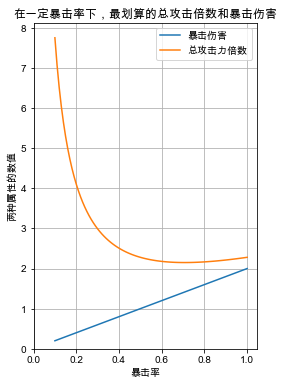

In [72]:
plt.rcParams['font.sans-serif'] = ['Arial Unicode MS']

cchance = np.arange(0.1, 1.01, 0.01)
cdamage = cchance * 2
attack_ratio = 1.52 * (1/(2*cchance) + cchance)

fig, ax = plt.subplots(figsize=(4, 6))
ax.plot(cchance, cdamage, label='暴击伤害')
ax.plot(cchance, attack_ratio, label='总攻击力倍数')
ax.set_title('在一定暴击率下，最划算的总攻击倍数和暴击伤害')
ax.set_ylabel('两种属性的数值')
ax.set_xlabel('暴击率')
ax.legend(loc='best')
ax.set_ylim(0)
ax.set_xlim(0)
ax.grid()

## 考虑元素反应的情况下

In [76]:
characters = pd.DataFrame(
    [
        ['迪卢克', '双手剑', 335, .05 + .192, 0.5, .2, 0],
    ],
    columns=['名字', '武器类型', '攻击力', '暴击率', '暴击伤害', '额外增伤', '反应强度'],
)

characters

,名字,武器类型,攻击力,暴击率,暴击伤害,额外增伤,反应强度
0,迪卢克,双手剑,335,0.242,0.5,0.2,0


In [106]:
weapons = pd.DataFrame(
    [
        # 30% 血量以下的敌人攻击力增加 40%，持续 12s，冷却 30s，计算期望增加攻击力 30%*40%*12/30
        ['狼的末路', '双手剑', 608, .496 + .2 + .3*.4*12/30, 0, 0, 0, 0],
        # 螭骨剑的增伤效果一般在实战中视为为 2 层左右
        ['螭骨剑', '双手剑', 510, 0, .276, 0, .06 * 2, 0],
        # 试作古华的伤害特效不考虑
        ['试作古华', '双手剑', 565, .276, 0, 0, 0, 0],
        ['雨裁', '双手剑', 510, 0, 0, 0, .15, 165],
        
    ],
    columns=['名称', '武器类型', '攻击力', '百分比攻击力', '暴击率', '暴击伤害', '额外增伤', '元素精通'],
)

weapons

,名称,武器类型,攻击力,百分比攻击力,暴击率,暴击伤害,额外增伤,元素精通
0,狼的末路,双手剑,608,0.744,0.000,0,0.00,0
1,螭骨剑,双手剑,510,0.000,0.276,0,0.12,0
2,试作古华,双手剑,565,0.276,0.000,0,0.00,0
3,雨裁,双手剑,510,0.000,0.000,0,0.15,165


In [81]:
artifacts = pd.DataFrame(
    [
        # 卢姥爷释放元素战技三次一共增加元素伤害 15% + 7.5%*3 = 37.5%
        ['炽烈的炎之魔女', 0, 0, 0, 0, .15 + .075*3, .15],
        
    ],
    columns=['名称', '数值攻击力', '百分比攻击力', '暴击率', '暴击伤害', '额外增伤', '反应强度'],
)

artifacts

,名称,数值攻击力,百分比攻击力,暴击率,暴击伤害,额外增伤,反应强度
0,炽烈的炎之魔女,0,0,0,0,0.375,0.15


In [82]:
attr_names = [
    '主_百分比攻击力', 
    '主_元素伤害', 
    '主_暴击率', 
    '主_暴击伤害',
    '主_元素精通',
    '副_数值攻击力',
    '副_百分比攻击力',
    '副_暴击率',
    '副_暴击伤害',
    '副_元素精通',
]
attr_values = [.466, .466, .311, .622, 187, 17, .05, .033, .066, 20]

In [85]:
def gen_sub_stats_re(sands, goblet, circlet):
    values = [0] * (len(attr_names) * 2)
    half_len = int(len(values) / 2)
    
    # 录入主词条
    values[sands] += attr_values[sands]
    values[goblet] += attr_values[goblet]
    values[circlet] += attr_values[circlet]
    values[half_len + sands] += 1
    values[half_len + goblet] += 1
    values[half_len + circlet] += 1
    
    # 初始出现的副词条（假设最好的情况）
    ini_atk = 3
    ini_patk = 5 - values[half_len]
    ini_crate = 5 - values[half_len + 2]
    ini_cdmg = 5 - values[half_len + 3]
    ini_em = 5 - values[half_len + 4]
    
    # 升级出现的副词条(枚举总数不超过 25)
    print('沙、杯、帽')
    print(sands, goblet, circlet)
    max_idx_patk = min(ini_patk * 5, 25)
    for idx_patk in range(max_idx_patk + 1):
        max_idx_crate = min(idx_patk + ini_crate * 5, 25)
        for idx_crate in range(idx_patk, max_idx_crate + 1):
            max_idx_cdmg = min(idx_crate + ini_cdmg * 5, 25)
            for idx_cdmg in range(idx_crate, max_idx_cdmg + 1):
                max_idx_em = idx_cdmg + ini_em * 5
                if max_idx_em < 25:
                    continue
                up_atk = 0
                up_patk = idx_patk
                up_crate = idx_crate - idx_patk
                up_cdmg = idx_cdmg - idx_crate
                up_em = 25 - idx_cdmg
                values[half_len + 5] = ini_atk + up_atk
                values[half_len + 6] = ini_patk + up_patk
                values[half_len + 7] = ini_crate + up_crate
                values[half_len + 8] = ini_cdmg + up_cdmg
                values[half_len + 9] = ini_em + up_em
                values[5] = values[half_len + 5] * attr_values[5]
                values[6] = values[half_len + 6] * attr_values[6]
                values[7] = values[half_len + 7] * attr_values[7]
                values[8] = values[half_len + 8] * attr_values[8]
                values[9] = values[half_len + 9] * attr_values[9]
                equip_values.loc[len(equip_values)] = values

In [95]:
%%time
attr_cols = attr_names + [name + '_次数' for name in attr_names]
equip_values = pd.DataFrame(columns=attr_cols)

for sands in [0, 4]:
    for goblet in [0, 1, 4]:
        for circlet in [0, 2, 3, 4]:
            gen_sub_stats_re(sands, goblet, circlet)

equip_values.insert(0, '主_数值攻击力', 311)

equip_values.head(10)

沙、杯、帽
0 0 0
沙、杯、帽
0 0 2
沙、杯、帽
0 0 3
沙、杯、帽
0 0 4
沙、杯、帽
0 1 0
沙、杯、帽
0 1 2
沙、杯、帽
0 1 3
沙、杯、帽
0 1 4
沙、杯、帽
0 4 0
沙、杯、帽
0 4 2
沙、杯、帽
0 4 3
沙、杯、帽
0 4 4
沙、杯、帽
4 0 0
沙、杯、帽
4 0 2
沙、杯、帽
4 0 3
沙、杯、帽
4 0 4
沙、杯、帽
4 1 0
沙、杯、帽
4 1 2
沙、杯、帽
4 1 3
沙、杯、帽
4 1 4
沙、杯、帽
4 4 0
沙、杯、帽
4 4 2
沙、杯、帽
4 4 3
沙、杯、帽
4 4 4
CPU times: user 3min 33s, sys: 36.9 s, total: 4min 10s
Wall time: 4min 19s


,主_数值攻击力,主_百分比攻击力,主_元素伤害,主_暴击率,主_暴击伤害,主_元素精通,副_数值攻击力,副_百分比攻击力,副_暴击率,副_暴击伤害,副_元素精通,主_百分比攻击力_次数,主_元素伤害_次数,主_暴击率_次数,主_暴击伤害_次数,主_元素精通_次数,副_数值攻击力_次数,副_百分比攻击力_次数,副_暴击率_次数,副_暴击伤害_次数,副_元素精通_次数
0,311,1.398,0.0,0.0,0.0,0.0,51.0,0.1,0.165,0.330,600.0,3.0,0.0,0.0,0.0,0.0,3.0,2.0,5.0,5.0,30.0
1,311,1.398,0.0,0.0,0.0,0.0,51.0,0.1,0.165,0.396,580.0,3.0,0.0,0.0,0.0,0.0,3.0,2.0,5.0,6.0,29.0
2,311,1.398,0.0,0.0,0.0,0.0,51.0,0.1,0.165,0.462,560.0,3.0,0.0,0.0,0.0,0.0,3.0,2.0,5.0,7.0,28.0
3,311,1.398,0.0,0.0,0.0,0.0,51.0,0.1,0.165,0.528,540.0,3.0,0.0,0.0,0.0,0.0,3.0,2.0,5.0,8.0,27.0
4,311,1.398,0.0,0.0,0.0,0.0,51.0,0.1,0.165,0.594,520.0,3.0,0.0,0.0,0.0,0.0,3.0,2.0,5.0,9.0,26.0
5,311,1.398,0.0,0.0,0.0,0.0,51.0,0.1,0.165,0.660,500.0,3.0,0.0,0.0,0.0,0.0,3.0,2.0,5.0,10.0,25.0
6,311,1.398,0.0,0.0,0.0,0.0,51.0,0.1,0.165,0.726,480.0,3.0,0.0,0.0,0.0,0.0,3.0,2.0,5.0,11.0,24.0
7,311,1.398,0.0,0.0,0.0,0.0,51.0,0.1,0.165,0.792,460.0,3.0,0.0,0.0,0.0,0.0,3.0,2.0,5.0,12.0,23.0
8,311,1.398,0.0,0.0,0.0,0.0,51.0,0.1,0.165,0.858,440.0,3.0,0.0,0.0,0.0,0.0,3.0,2.0,5.0,13.0,22.0
9,311,1.398,0.0,0.0,0.0,0.0,51.0,0.1,0.165,0.924,420.0,3.0,0.0,0.0,0.0,0.0,3.0,2.0,5.0,14.0,21.0


In [98]:
len(equip_values)

73434

In [99]:
origin_names = ['数值攻击力', '百分比攻击力', '元素伤害', '暴击率', '暴击伤害', '元素精通']
for name in origin_names:
    main_stat = equip_values['主_' + name]
    sub_stat = (
        ('副_' + name) in equip_values.columns and 
        equip_values['副_' + name]
    )
    equip_values['总_' + name] = main_stat + sub_stat

equip_values['总_额外增伤'] = equip_values['总_元素伤害']
# 反应强度暂时等于 0，后面会加
equip_values['总_反应强度'] = 0
equip_values.head()

,主_数值攻击力,主_百分比攻击力,主_元素伤害,主_暴击率,主_暴击伤害,主_元素精通,副_数值攻击力,副_百分比攻击力,副_暴击率,副_暴击伤害,副_元素精通,主_百分比攻击力_次数,主_元素伤害_次数,主_暴击率_次数,主_暴击伤害_次数,主_元素精通_次数,副_数值攻击力_次数,副_百分比攻击力_次数,副_暴击率_次数,副_暴击伤害_次数,副_元素精通_次数,总_数值攻击力,总_百分比攻击力,总_元素伤害,总_暴击率,总_暴击伤害,总_元素精通,总_额外增伤,总_反应强度
0,311,1.398,0.0,0.0,0.0,0.0,51.0,0.1,0.165,0.330,600.0,3.0,0.0,0.0,0.0,0.0,3.0,2.0,5.0,5.0,30.0,362.0,1.498,0.0,0.165,0.330,600.0,0.0,0
1,311,1.398,0.0,0.0,0.0,0.0,51.0,0.1,0.165,0.396,580.0,3.0,0.0,0.0,0.0,0.0,3.0,2.0,5.0,6.0,29.0,362.0,1.498,0.0,0.165,0.396,580.0,0.0,0
2,311,1.398,0.0,0.0,0.0,0.0,51.0,0.1,0.165,0.462,560.0,3.0,0.0,0.0,0.0,0.0,3.0,2.0,5.0,7.0,28.0,362.0,1.498,0.0,0.165,0.462,560.0,0.0,0
3,311,1.398,0.0,0.0,0.0,0.0,51.0,0.1,0.165,0.528,540.0,3.0,0.0,0.0,0.0,0.0,3.0,2.0,5.0,8.0,27.0,362.0,1.498,0.0,0.165,0.528,540.0,0.0,0
4,311,1.398,0.0,0.0,0.0,0.0,51.0,0.1,0.165,0.594,520.0,3.0,0.0,0.0,0.0,0.0,3.0,2.0,5.0,9.0,26.0,362.0,1.498,0.0,0.165,0.594,520.0,0.0,0


In [149]:
def fit_ct(ct_name, af_name, EAR, p):
    results = []
    
    cts = characters[characters['名字'] == ct_name]
    wps = weapons[weapons['武器类型'] == cts['武器类型'].values[0]]
    afs = artifacts[artifacts['名称'] == af_name]
    
    for _, ct in cts.iterrows():
        for _, wp in wps.iterrows():
            for _, af in afs.iterrows():
                print(ct['名字'], wp['名称'], af['名称'])
                # 加成人物和武器的属性
                e_values = equip_values.copy()
                for attr in ct.index[3:]:
                    e_values['总_' + attr] += ct[attr]
                for attr in wp.index[3:]:
                    e_values['总_' + attr] += wp[attr]
                for attr in af.index[1:]:
                    e_values['总_' + attr] += af[attr]
                    
                # 前面可能有圣遗物直接加反应强度，所以这边要 += 而不是 =
                e_values['总_反应强度'] += (
                    6.665 - 
                    9340 / (e_values['总_元素精通']+1401)
                )

                print(ct['攻击力'], wp['攻击力'])

                e_values['期望伤害'] = (
                    (
                        (ct['攻击力'] + wp['攻击力']) *
                        (1 + e_values['总_百分比攻击力']) + 
                        e_values['总_数值攻击力']
                    ) *
                    (1 + e_values['总_额外增伤']) *
                    (
                        1 + 
                        # 暴击率超过 1，只能按 1 计算
                        e_values['总_暴击率'].where(e_values['总_暴击率'] < 1, 1) * 
                        e_values['总_暴击伤害']
                    ) *
                    (
                        1 - p +
                        EAR * 
                        (
                            1 + e_values['总_反应强度']
                        ) * p
                    )
                )

                e_values['总攻击力倍数'] = (
                    (
                        (ct['攻击力'] + wp['攻击力']) *
                        (1 + e_values['总_百分比攻击力']) + 
                        e_values['总_数值攻击力']
                    ) / 
                    (ct['攻击力'] + wp['攻击力'])
                )

                e_values['暴击率推导的总攻击力倍数'] = 1.52 * (
                    1 / (2 * e_values['总_暴击率']) + e_values['总_暴击率']
                )

                res = e_values.sort_values('期望伤害', ascending=False)
                print(res.iloc[:5])
                results.append(res)
                # res.to_csv(ct['名字'] + '_' + wp['名称'] + '_' + af['名称'] +'_考虑精通.csv')

    return results

In [150]:
results = fit_ct('迪卢克', '炽烈的炎之魔女', 1.5, .6)

迪卢克 狼的末路 炽烈的炎之魔女
335 608
       主_数值攻击力  主_百分比攻击力  主_元素伤害  主_暴击率  主_暴击伤害  主_元素精通  副_数值攻击力  副_百分比攻击力  \
55786      311       0.0   0.466  0.000   0.622   187.0     51.0      0.25   
52468      311       0.0   0.466  0.311   0.000   187.0     51.0      0.25   
52469      311       0.0   0.466  0.311   0.000   187.0     51.0      0.25   
55775      311       0.0   0.466  0.000   0.622   187.0     51.0      0.25   
52487      311       0.0   0.466  0.311   0.000   187.0     51.0      0.25   

       副_暴击率  副_暴击伤害  副_元素精通  主_百分比攻击力_次数  主_元素伤害_次数  主_暴击率_次数  主_暴击伤害_次数  \
55786  0.693   0.726   120.0          0.0        1.0       0.0        1.0   
52468  0.363   1.320   140.0          0.0        1.0       1.0        0.0   
52469  0.363   1.386   120.0          0.0        1.0       1.0        0.0   
55775  0.660   0.726   140.0          0.0        1.0       0.0        1.0   
52487  0.396   1.320   120.0          0.0        1.0       1.0        0.0   

       主_元素精通_次数  副_数值攻击力_次数  副_百分比攻击力_次数  

In [90]:
results[0].head()

,主_数值攻击力,主_百分比攻击力,主_元素伤害,主_暴击率,主_暴击伤害,主_元素精通,副_数值攻击力,副_百分比攻击力,副_暴击率,副_暴击伤害,副_元素精通,主_百分比攻击力_次数,主_元素伤害_次数,主_暴击率_次数,主_暴击伤害_次数,主_元素精通_次数,副_数值攻击力_次数,副_百分比攻击力_次数,副_暴击率_次数,副_暴击伤害_次数,副_元素精通_次数,总_数值攻击力,总_百分比攻击力,总_元素伤害,总_暴击率,总_暴击伤害,总_元素精通,总_额外增伤,总_反应强度,期望伤害,总攻击力倍数,暴击率推导的总攻击力倍数
55786,311,0.0,0.466,0.000,0.622,187.0,51.0,0.25,0.693,0.726,120.0,0.0,1.0,0.0,1.0,1.0,3.0,5.0,21.0,11.0,6.0,362.0,0.994,0.466,0.935,1.848,307.0,1.041,1.346616,31360.419073,2.377881,2.234034
52468,311,0.0,0.466,0.311,0.000,187.0,51.0,0.25,0.363,1.320,140.0,0.0,1.0,1.0,0.0,1.0,3.0,5.0,11.0,20.0,7.0,362.0,0.994,0.466,0.916,1.820,327.0,1.041,1.409907,31357.211024,2.377881,2.222014
52469,311,0.0,0.466,0.311,0.000,187.0,51.0,0.25,0.363,1.386,120.0,0.0,1.0,1.0,0.0,1.0,3.0,5.0,11.0,21.0,6.0,362.0,0.994,0.466,0.916,1.886,307.0,1.041,1.346616,31356.924210,2.377881,2.222014
55775,311,0.0,0.466,0.000,0.622,187.0,51.0,0.25,0.660,0.726,140.0,0.0,1.0,0.0,1.0,1.0,3.0,5.0,20.0,11.0,7.0,362.0,0.994,0.466,0.902,1.848,327.0,1.041,1.409907,31354.577466,2.377881,2.213612
52487,311,0.0,0.466,0.311,0.000,187.0,51.0,0.25,0.396,1.320,120.0,0.0,1.0,1.0,0.0,1.0,3.0,5.0,12.0,20.0,6.0,362.0,0.994,0.466,0.949,1.820,307.0,1.041,1.346616,31352.371691,2.377881,2.243323


In [104]:
results[1].head()

,主_数值攻击力,主_百分比攻击力,主_元素伤害,主_暴击率,主_暴击伤害,主_元素精通,副_数值攻击力,副_百分比攻击力,副_暴击率,副_暴击伤害,副_元素精通,主_百分比攻击力_次数,主_元素伤害_次数,主_暴击率_次数,主_暴击伤害_次数,主_元素精通_次数,副_数值攻击力_次数,副_百分比攻击力_次数,副_暴击率_次数,副_暴击伤害_次数,副_元素精通_次数,总_数值攻击力,总_百分比攻击力,总_元素伤害,总_暴击率,总_暴击伤害,总_元素精通,总_额外增伤,总_反应强度,期望伤害,总攻击力倍数,暴击率推导的总攻击力倍数
58120,311,0.0,0.466,0.0,0.622,187.0,51.0,0.80,0.363,0.660,120.0,0.0,1.0,0.0,1.0,1.0,3.0,16.0,11.0,10.0,6.0,362.0,0.80,0.466,0.881,1.782,307.0,1.161,1.346616,26268.794833,2.228402,2.201776
58000,311,0.0,0.466,0.0,0.622,187.0,51.0,0.75,0.396,0.660,120.0,0.0,1.0,0.0,1.0,1.0,3.0,15.0,12.0,10.0,6.0,362.0,0.75,0.466,0.914,1.782,307.0,1.161,1.346616,26266.987714,2.178402,2.220790
57990,311,0.0,0.466,0.0,0.622,187.0,51.0,0.75,0.363,0.660,140.0,0.0,1.0,0.0,1.0,1.0,3.0,15.0,11.0,10.0,7.0,362.0,0.75,0.466,0.881,1.782,327.0,1.161,1.409907,26261.704750,2.178402,2.201776
57991,311,0.0,0.466,0.0,0.622,187.0,51.0,0.75,0.363,0.726,120.0,0.0,1.0,0.0,1.0,1.0,3.0,15.0,11.0,11.0,6.0,362.0,0.75,0.466,0.881,1.848,307.0,1.161,1.346616,26260.392859,2.178402,2.201776
58119,311,0.0,0.466,0.0,0.622,187.0,51.0,0.80,0.363,0.594,140.0,0.0,1.0,0.0,1.0,1.0,3.0,16.0,11.0,9.0,7.0,362.0,0.80,0.466,0.881,1.716,327.0,1.161,1.409907,26256.659232,2.228402,2.201776


In [108]:
results[3].head()

,主_数值攻击力,主_百分比攻击力,主_元素伤害,主_暴击率,主_暴击伤害,主_元素精通,副_数值攻击力,副_百分比攻击力,副_暴击率,副_暴击伤害,副_元素精通,主_百分比攻击力_次数,主_元素伤害_次数,主_暴击率_次数,主_暴击伤害_次数,主_元素精通_次数,副_数值攻击力_次数,副_百分比攻击力_次数,副_暴击率_次数,副_暴击伤害_次数,副_元素精通_次数,总_数值攻击力,总_百分比攻击力,总_元素伤害,总_暴击率,总_暴击伤害,总_元素精通,总_额外增伤,总_反应强度,期望伤害,总攻击力倍数,暴击率推导的总攻击力倍数
18827,311,0.466,0.466,0.000,0.622,0.0,51.0,0.30,0.660,0.660,140.0,1.0,1.0,0.0,1.0,0.0,3.0,6.0,20.0,10.0,7.0,362.0,0.766,0.466,0.902,1.782,305.0,1.191,1.340205,26547.894237,2.194402,2.213612
15510,311,0.466,0.466,0.311,0.000,0.0,51.0,0.30,0.330,1.320,140.0,1.0,1.0,1.0,0.0,0.0,3.0,6.0,10.0,20.0,7.0,362.0,0.766,0.466,0.883,1.820,305.0,1.191,1.340205,26544.798942,2.194402,2.202862
15797,311,0.466,0.466,0.311,0.000,0.0,51.0,0.35,0.330,1.254,140.0,1.0,1.0,1.0,0.0,0.0,3.0,7.0,10.0,19.0,7.0,362.0,0.816,0.466,0.883,1.754,305.0,1.191,1.340205,26542.728225,2.244402,2.202862
15509,311,0.466,0.466,0.311,0.000,0.0,51.0,0.30,0.330,1.254,160.0,1.0,1.0,1.0,0.0,0.0,3.0,6.0,10.0,19.0,8.0,362.0,0.766,0.466,0.883,1.754,325.0,1.191,1.403644,26542.636679,2.194402,2.202862
15527,311,0.466,0.466,0.311,0.000,0.0,51.0,0.30,0.363,1.254,140.0,1.0,1.0,1.0,0.0,0.0,3.0,6.0,11.0,19.0,7.0,362.0,0.766,0.466,0.916,1.754,305.0,1.191,1.340205,26540.766913,2.194402,2.222014


Text(0.5, 0.98, '特定暴击率下，其他属性的最划算数值\n（反应系数：1.5，反应伤害占比：60%，其他反应增强百分比（如魔女套）：15%）')

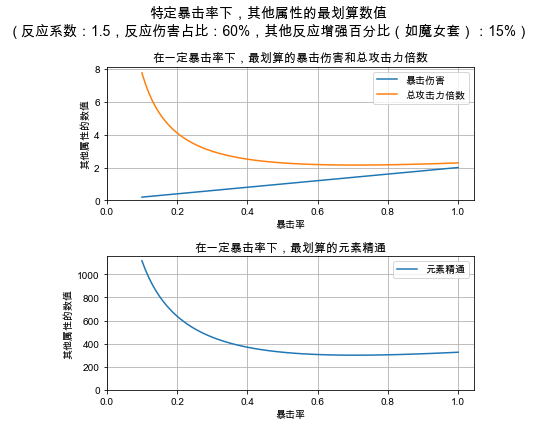

In [148]:
plt.rcParams['font.sans-serif'] = ['Arial Unicode MS']

EAR = 1.5
p = .6
n = .15

crate = np.arange(0.1, 1.01, 0.01)
cdmg = crate * 2
atk_ratio = 1.52 * (1/(2*cchance) + cchance)
a = (
    .066 / (20 * 9340) * 
    (
        (1 - p) / (p * EAR) +
        7.665 + n
    )
)
b = -.066/20
c = -(1 + 2 * crate ** 2) / crate
em = (-b + (b ** 2 - 4 * a * c) ** 0.5) / (2 * a) - 1401

y_labels = [['暴击伤害', '总攻击力倍数'], ['元素精通']]
y_values = [[cdmg, atk_ratio], [em]]

fig, axes = plt.subplots(2, 1, figsize=(6, 6), tight_layout=True)
for i in range(len(y_labels)):
    attr_title = ''
    for j in range(len(y_labels[i])):
        axes[i].plot(crate, y_values[i][j], label=y_labels[i][j])
        attr_title += '和' if j != 0 else ''
        attr_title += y_labels[i][j]
    axes[i].set_title('在一定暴击率下，最划算的' + attr_title)
    axes[i].set_ylabel('其他属性的数值')
    axes[i].set_xlabel('暴击率')
    axes[i].set_ylim(0)
    axes[i].set_xlim(0)
    axes[i].legend(loc='best')
    axes[i].grid()


fig.suptitle(
    '特定暴击率下，其他属性的最划算数值\n'
    '（反应系数：{:.1f}，'
    '反应伤害占比：{:.0%}，'
    '其他反应增强百分比（如魔女套）：{:.0%}）'
    .format(EAR, p, n), 
    fontsize=14
)